# PyKOALA Data Reduction Sequence (Standard stars)

This notebook contains the basic reduction steps that can be done with pyKOALA for the KOALA instrument.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pykoala import __version__
import warnings
import importlib
# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.9.0+0.g66e15e6.dirty


In [2]:
%load_ext autoreload
%autoreload 2

First, let's import a basic module to handle the RSS data:

In [3]:
from pykoala.instruments.koala_ifu import koala_rss

The koala_rss is a *DataContainer* that will be used to store the RSS data and track all the changes applied to it.

Now let's load some data that we have partially reduced with 2dfdr. The target will be the spectrophotometric standard star HR7596:

In [4]:
# List of RSS objects
std_star_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'red'
path_to_data = 'data'

for i in [28, 29, 30]:
    filename = f"{path_to_data}/27feb{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    print(f"File {filename} corresponds to object {rss.info['name']}")
    std_star_rss.append(rss)

File data/27feb20028red.fits corresponds to object HILT600 A
File data/27feb20029red.fits corresponds to object HILT600 B 3S
File data/27feb20030red.fits corresponds to object HILT600 C 3W


Now let us start applying some corrections to the data!

In this tutorial, we will consider the following corrections:
- Instrumental throughput
- Atmospheric extinction
- Telluric absorption
- Sky emission

Some of these corrections might not be relevant at a particular wavelength regime. For example, the blue arm of the AAOMega spectrograph 3600-5000 A is not affected by the telluric absorption.

# Corrections
## Instrumental throughput

In [5]:
from pykoala.corrections.throughput import ThroughputCorrection
from pykoala.plotting.qc_plot import qc_throughput

The throughput correction accounts for the differences in the efficiency of each fibre in the instrument. This effect also depends on the wavelength that we are using.

In pyKOALA (at least version <= 0.1.1) this can be computed from a set of input rss files that correspond to flat exposures as follows

In [6]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput = ThroughputCorrection.create_throughput_from_rss(flat_rss, clear_nan=True)

throughput_corr = ThroughputCorrection(throughput=throughput)
for i in range(len(std_star_rss)):
    std_star_rss[i] = throughput_corr.apply(std_star_rss[i])

Applying nearest neighbour interpolation to remove NaN values


We can assess the quality of our resulting throughput correction by using the built-in quality control plotting functions

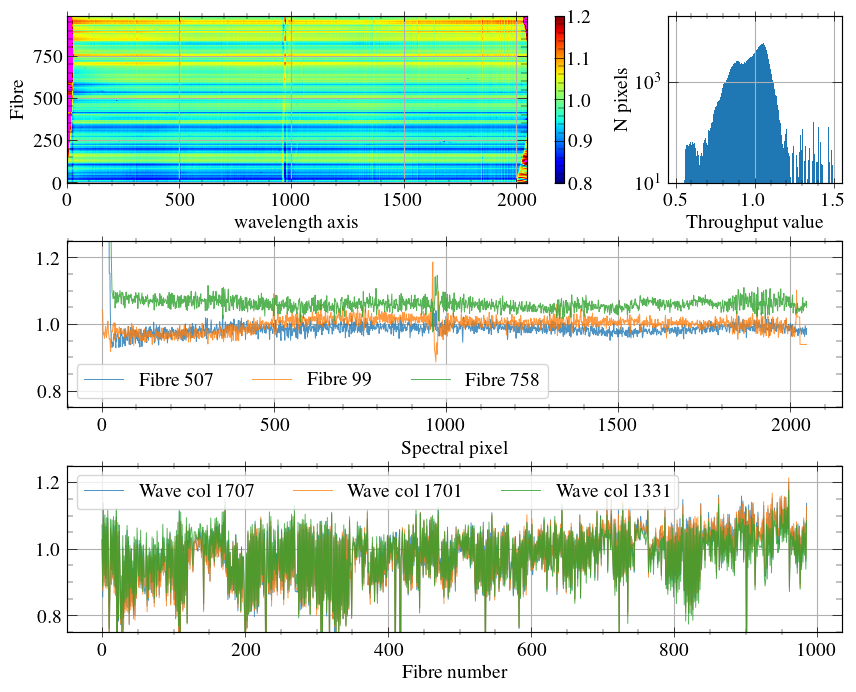

In [7]:
throughput_fig = qc_throughput(throughput)
plt.show(throughput_fig)

Each correction is recorded within the `log` attribute:

In [8]:
for key, val in std_star_rss[0].log.items():
    print(f"Process *{key}* with info:\n   {val}")

Process *read* with info:
   {'comment': '- RSS read from  27feb20028red.fits', 'index': None}
Process *mask from file* with info:
   {'comment': None, 'index': 0}
Process *blue edge* with info:
   {'comment': None, 'index': 1}
Process *red edge* with info:
   {'comment': None, 'index': 2}
Process *cosmic* with info:
   {'comment': None, 'index': 3}
Process *extreme negative* with info:
   {'comment': None, 'index': 4}
Process *wavelength fix* with info:
   {'comment': None, 'index': None, 'sol': []}


## Atmospheric extinction

In [9]:
from pykoala.corrections.atmospheric_corrections import AtmosphericExtCorrection

AtmosphericExtCorrection?

Init signature:
AtmosphericExtCorrection(
    extinction_correction=None,
    extinction_correction_wave=None,
    extinction_file='/home/pcorchoc/Develop/koala/src/pykoala/corrections/../input_data/observatory_extinction/ssoextinct.dat',
    verbose=False,
)
Docstring:     
Atmospheric Extinction Correction.

Description
-----------
This module accounts for the brightness reduction caused due to the absorption of 
photons by the atmosphere.

For a given observed (F_obs) and intrinsic flux F_int, the extinction E takes the form:
F_obs(lambda) = E(lambda) * F_int(lambda) = 10^(0.4 * airmass * eta(lambda))
where eta corresponds to the extinction curve that depends on the frequency.

Attributes
----------
- extinction_correction: (np.ndarray, optional, default=None)
    Atmospheric extinction correction function.
- extinction_correction_wave: (np.ndarray, optional, default=None)
    Atmospheric extinction correction function wavelength array.
- extinction_file: (str, default=input_data/ob

In [10]:
atm_ext_corr = AtmosphericExtCorrection(verbose=True)

[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] Loading atmospheric extinction model from:
 /home/pcorchoc/Develop/koala/src/pykoala/corrections/../input_data/observatory_extinction/ssoextinct.dat


In [11]:
for i in range(len(std_star_rss)):
    std_star_rss[i] = atm_ext_corr.apply(std_star_rss[i])

[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.23 airmass)
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.22 airmass)
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.22 airmass)


## Telluric absorption

In [12]:
from pykoala.corrections.sky import TelluricCorrection, combine_telluric_corrections

There are two ways of estimating the Tellucir correction: using a default model or using an empirical approach from the data.

In this example, we will compute a telluric correction for each input RSS, and later we will combine all of them into a final one. Alternatively, the user might want to first combine all the RSS data, and then compute the effective telluric absorption correction.

[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
[Correction: TelluricCorretion] Applying telluric correction to this star...


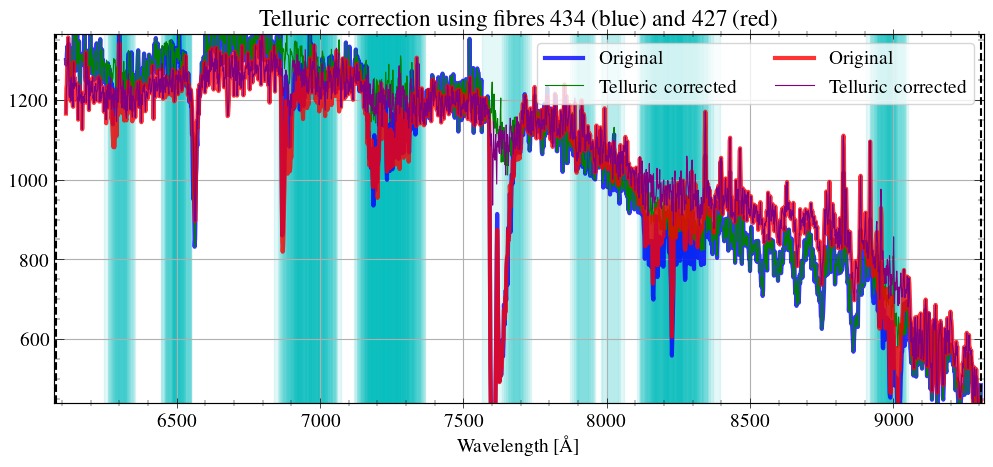

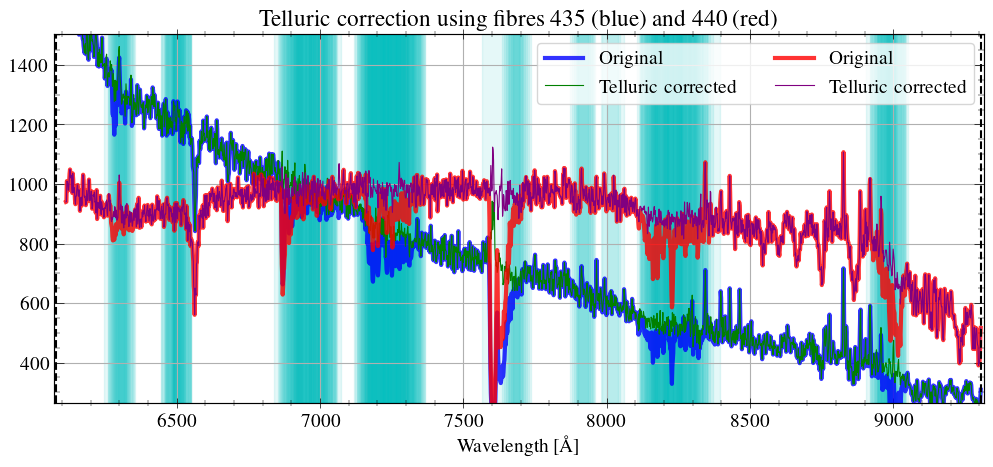

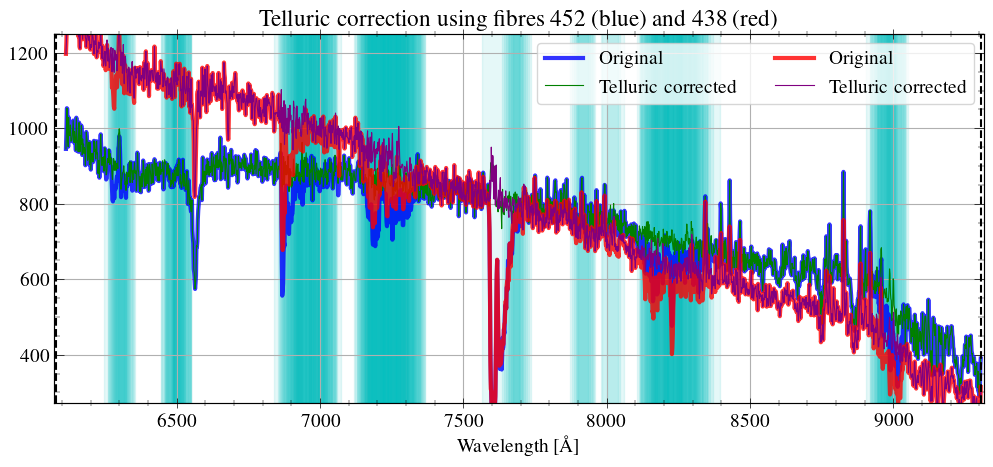

In [13]:
all_telluric_corrections = []
for i in range(len(std_star_rss)):
    telluric_correction = TelluricCorrection(std_star_rss[i], verbose=True)
    _, fig = telluric_correction.telluric_from_model(
                plot=True, width=30)
    # Reopen the figure
    plt.figure(fig)
    
    # Apply the correction to the star
    std_star_rss[i] = telluric_correction.apply(std_star_rss[i])
    all_telluric_corrections.append(telluric_correction)


Combining input telluric corrections


(0.95, 2.5)

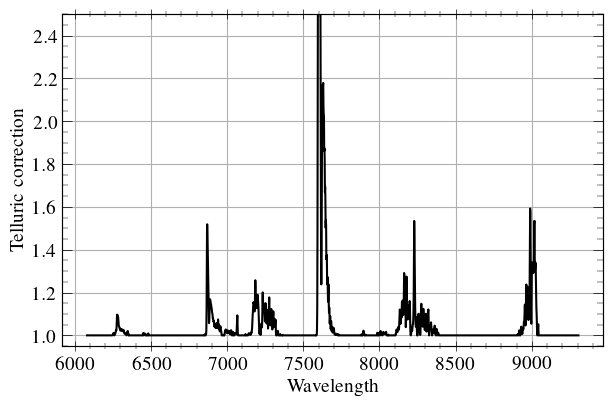

In [14]:
# Create the final telluric correction and save the result

final_telluric_correction = combine_telluric_corrections(all_telluric_corrections, ref_wavelength=std_star_rss[0].wavelength)
final_telluric_correction.save(filename=f"products/telluric_correction_{arm}.dat")

plt.figure()
plt.subplot(111)
plt.plot(final_telluric_correction.wlm, final_telluric_correction.telluric_correction, c='k')
plt.ylabel('Telluric correction')
plt.xlabel('Wavelength')
plt.ylim(0.95, 2.5)

## Sky emission

This is quite a difficult correction. In particular, KOALA does not count with auxiliary sky fibres that allow to estimate the sky brightness simultaneous to the acquisition of data. Therefore, the estimation of the sky contribution must be inferred from the science exposure or from offset sky frames taken between the observing sequence. 

At present, pyKOALA provides several ways to estimate a sky emission model... See the sky emission tutorial for a more detailed discussion.

In [15]:
from pykoala.corrections import sky
sky.SkyFromObject?

Init signature:
sky.SkyFromObject(
    dc,
    bckgr_estimator='mad',
    bckgr_params=None,
    source_mask_nsigma=3,
    remove_cont=False,
    cont_estimator='median',
    cont_estimator_args=None,
)
Docstring:     
Sky model based on a single Data Container.

Description
-----------
This class builds a sky emission model using the data
from a given Data Container that includes the contribution
of an additional source (i.e. star/galaxy).

Attributes
----------
Init docstring:
Params
------
- dc:
    Input DataContainer object
- bckgr_estimator: (str, default='mad')
    Background estimator method to be used.
- bckgr_params: (dict, default=None)
- remove_cont: (bool, default=False)
    If True, the continuum will be removed.
File:           ~/Develop/koala/src/pykoala/corrections/sky.py
Type:           type
Subclasses:     

[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction
[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction
[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction


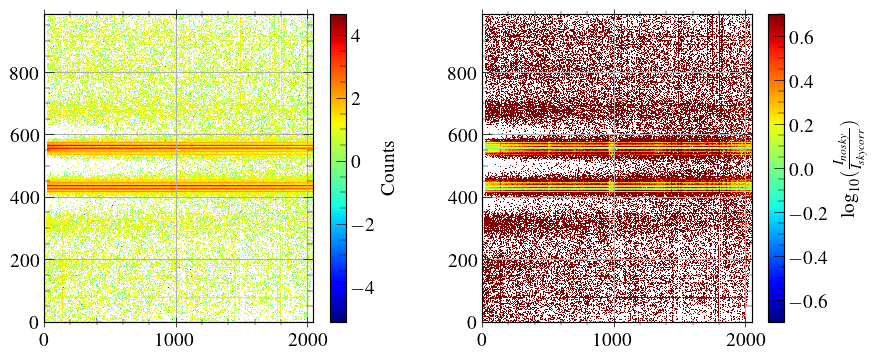

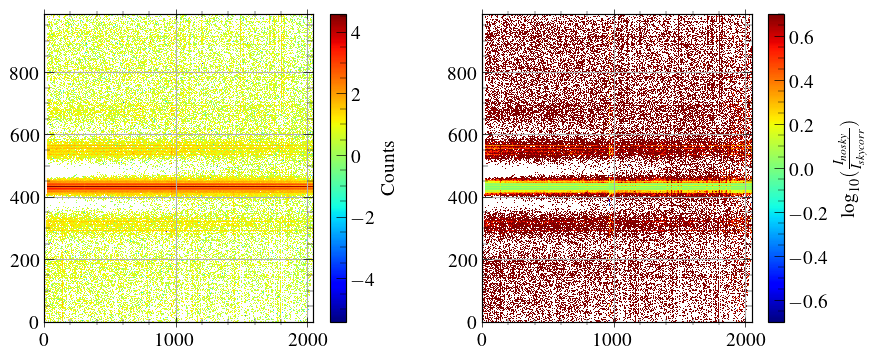

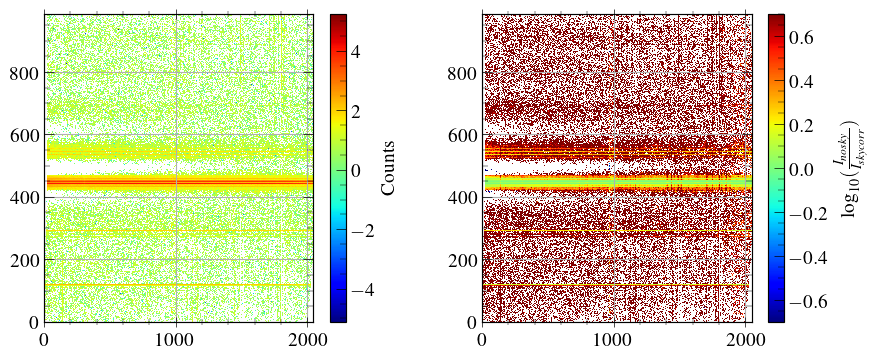

In [16]:
for i in range(len(std_star_rss)):
    skymodel = sky.SkyFromObject(std_star_rss[i], bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
    skycorrection = sky.SkySubsCorrection(skymodel)
    
    # Store the value of the RSS intensity before substraction
    intensity_no_sky = std_star_rss[i].intensity.copy()

    std_star_rss[i], _ = skycorrection.apply(std_star_rss[i])
    
    # Compare between the two versions of the data
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121)
    mappable = ax.imshow(np.log10(std_star_rss[i].intensity),
                         origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label='Counts')
    ax = fig.add_subplot(122)
    mappable = ax.imshow(np.log10(intensity_no_sky / std_star_rss[i].intensity),
                         vmin=-0.7, vmax=.7, origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label=r'$\log_{10}(\frac{I_{nosky}}{I_{skycorr}})$')
    plt.subplots_adjust(wspace=0.3)


# Cubing

For the final part of this tutorial, now we will see how to combine a set of RSS data into a 3D datacube.

- (optional) The first step would consists of registering the data, i.e., account for the spatial offset between the different frames eigther produced by instrumental innacuracies or due to the application of dithering patterns.
- ADR correction. The data might be affected by atmospheric differential refraction, producing a wavelength-dependent shift of the image.
- Cube interpolation.

## Registration

The registration of RSS frames is part of the Astrometry correction module. To register a set of stardad star frames, we will use the function `AstrometryCorrection.register_centroids` method.

In [17]:
from pykoala.corrections.astrometry import AstrometryCorrection

astrom_corr = AstrometryCorrection()

star_name = std_star_rss[0].info['name'].split()[0]
offsets, fig = astrom_corr.register_centroids(std_star_rss, object_name=star_name,
                                         qc_plot=True, centroider='gauss')
for offset in offsets:
    print("Offset (ra, dec) in arcsec: ", offset[0].to('arcsec'), offset[1].to('arcsec'))

for rss, offset in zip(std_star_rss, offsets):
    astrom_corr.apply(rss, offset=offset)

# Check that the corrections has been logged
print(rss.log)

[Correction: Astrometry] Reference star position:  <SkyCoord (ICRS): (ra, dec) in deg
    (101.30571895, 2.13741257)>
[Registration]  Data provided in RSS format --> creating a dummy datacube
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 98, 52)
[Cubing] Smoothing kernel scale: 4 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array
[Correction: Astrometry] Offset found (ra, dec):  3.36121 arcsec -2.54499 arcsec  (arcsec)
[Registration]  Data provided in RSS format --> creating a dummy datacube
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 98, 52)
[Cubing] Smoothing kernel scale: 4 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constr

<Figure size 697.385x431.008 with 0 Axes>

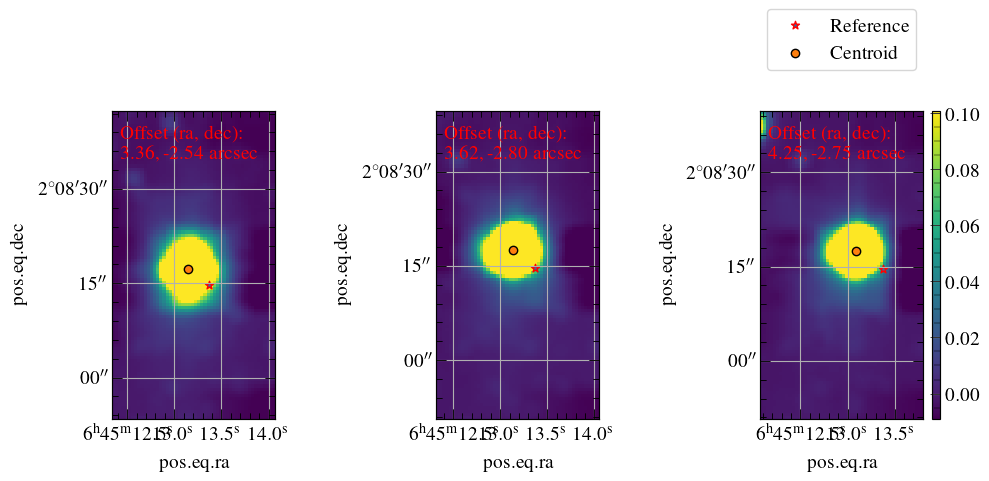

In [18]:
fig

## Atmospheric differential refraction

Accounting for this correction is way more easier with standard stars than with extended sources. The idea is to track the centroid of the star as function of wavelength to derive the offsets produced by the ADR.

In [19]:
from pykoala.corrections.atmospheric_corrections import get_adr

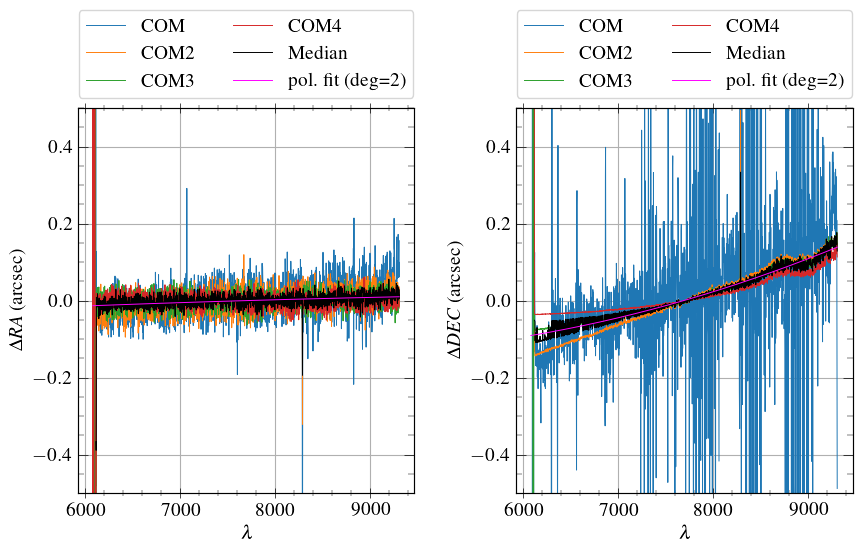

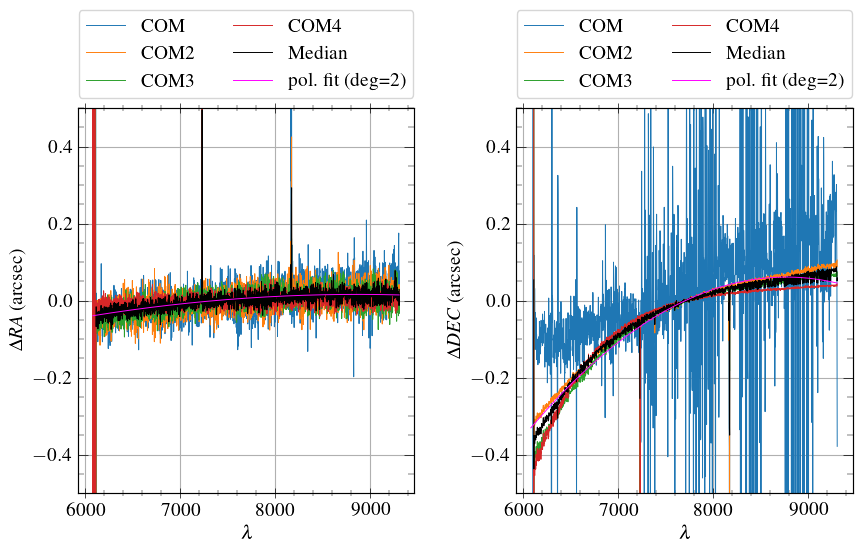

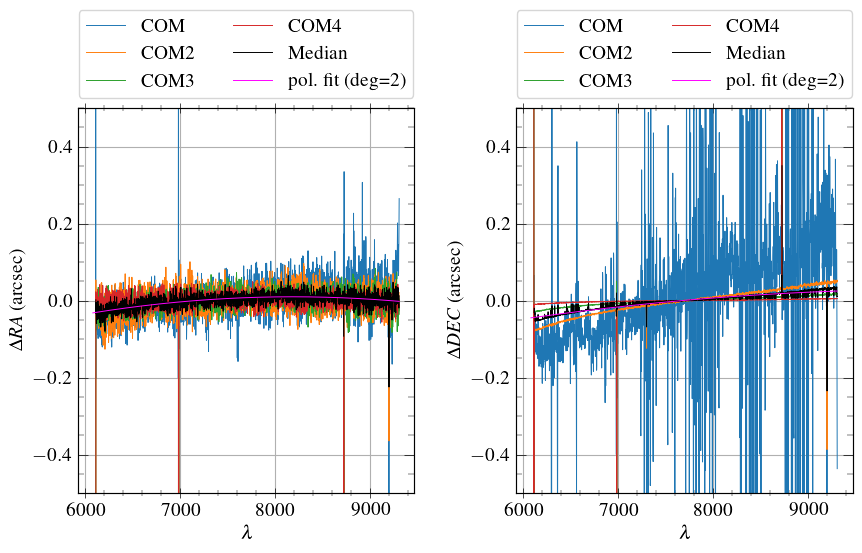

In [20]:
adr_corr_set = []

for rss in std_star_rss:
    adr_pol_ra, adr_pol_dec, fig = get_adr(rss, max_adr=0.5, pol_deg=2,
                                        plot=True)
    adr_corr_set.append([adr_pol_ra, adr_pol_dec])
    plt.show(plt.figure(fig))

## RSS cubing

In [21]:
from pykoala.cubing import build_cube, build_wcs
from pykoala.plotting.qc_plot import qc_cube

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- An `astropy.wcs.WCS` instance describing the dimensions of the cube, or a dictionary containing the basic information for initialising a `WCS`.
- The characteristic size of the kernel interpolation function expressed in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)]. Note that for the first two RSS we would be providing some corrections, while the latter would not be corrected.

To facilitate the creation of `WCS` objects, we provide a function `build_wcs`

In [22]:
# Number of pixels along the three dimensions
datacube_shape = (std_star_rss[0].wavelength.size, 40, 60)
# Reference position along the three axes.
ref_position = (std_star_rss[0].wavelength[0], np.mean(std_star_rss[0].info['fib_ra']), np.mean(std_star_rss[0].info['fib_dec']))  # (deg, deg)
# Spatial pixel scale size in deg
spatial_pixel_size = 1.0 / 3600
# Spectral pixel scale in angstrom
spectral_pixel_size = std_star_rss[0].wavelength[1] - std_star_rss[0].wavelength[0]

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

In [23]:


cube = build_cube(rss_set=std_star_rss,
                  wcs=wcs,
                  kernel_size_arcsec=1.0,
                  # Additional information that will be stored in the *info* dictionary
                  name=star_name)

print("CUBE INFO:\n", cube.hdul.info())

[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  INTENSITY     1 ImageHDU        29   (40, 60, 2048)   float64   
  2  VARIANCE      1 ImageHDU        29   (40, 60, 2048)   float64   
CUBE INFO:
 None


To assess the performance of the cubing, we can run the QC method *qc_cube*

[QCPLOT] Cube QC plot for:  HILT600


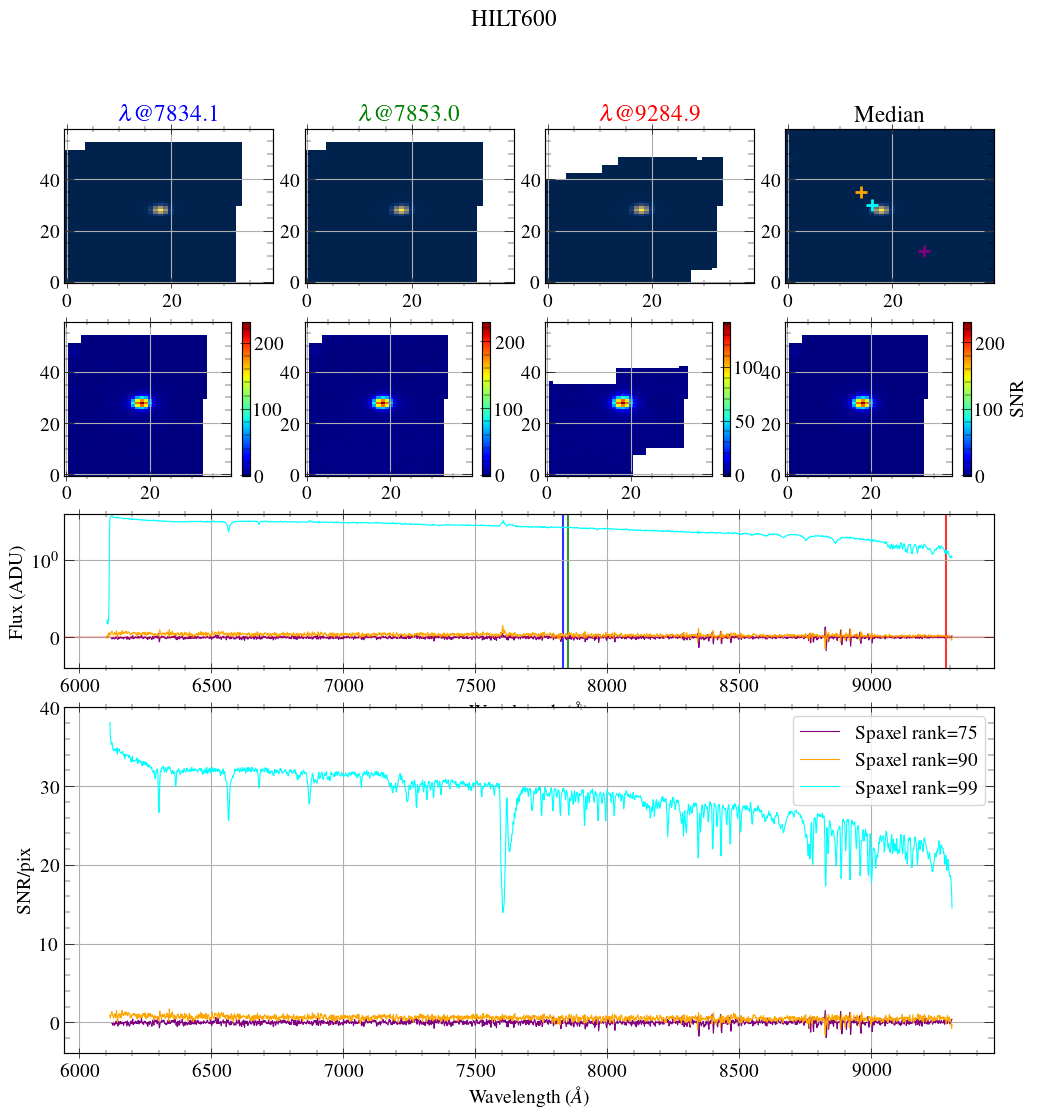

In [24]:
qc_cube(cube)


# Flux calibration

The final step will consists of deriving the instrumental response function (that would be used to correct the rest of the observed data). Although this is shown for just one star, ideally the final response function that will be used with the science data should be based on several standard stars.

In [117]:
from pykoala.corrections.flux_calibration import FluxCalibration

response_params = dict(pol_deg=None, spline=True, spline_args={'s':10}, gauss_smooth_sigma=100,
                           plot=True)
extract_args = dict(wave_range=None, wave_window=50, plot=True)

fcal = FluxCalibration()
results = fcal.auto(data=[cube],
                    calib_stars=[cube.info['name']],
                    fnames=None,
                    save='products',
                    extract_args=extract_args,
                    response_params=response_params)

[Correction: FluxCalibration] Initialising Flux Calibration (Spectral Throughput)
[Correction: FluxCalibration] 
----------------------------------------
Automatic calibration process for HILT600
----------------------------------------

[Correction: FluxCalibration] Loading template spectra
[Correction: FluxCalibration] Input name fhilt600, matches ['fhilt600' 'fhilt600']
[Correction: FluxCalibration] WARNING: More than one file found
[Correction: FluxCalibration] Extracting stellar flux from data
[Correction: FluxCalibration] Extracting star flux.
 -> Wavelength range=None
 -> Wavelength window=50

[Correction: FluxCalibration] Extracting flux from input Cube
[Correction: FluxCalibration] ...Fitting wavelength chuncks...
[Correction: FluxCalibration] Automatic fit bounds
[Correction: FluxCalibration] Automatic fit bounds
[Correction: FluxCalibration] Automatic fit bounds
[Correction: FluxCalibration] Automatic fit bounds
[Correction: FluxCalibration] Automatic fit bounds
[Correction:

dict_keys(['extraction', 'interp', 'wavelength', 'response', 'response_fig'])


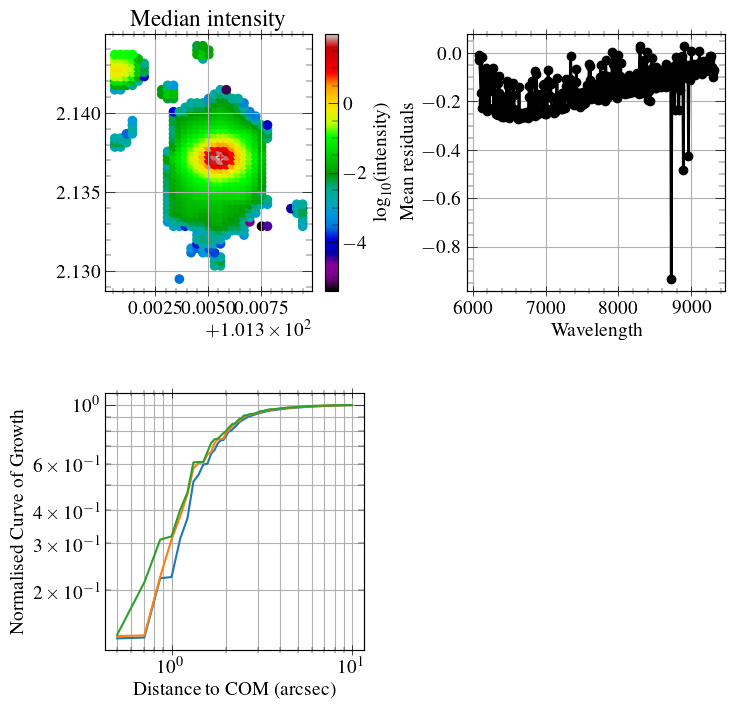

In [68]:
print(results['HILT600'].keys())
results['HILT600']['extraction']['figure']

Text(0.5, 0, 'Wavelength (AA)')

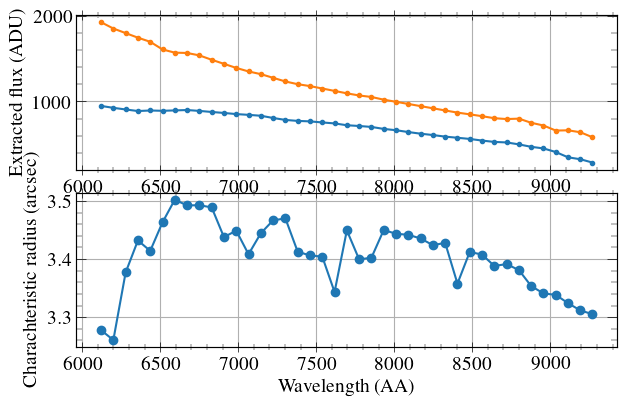

In [104]:
plt.figure()
plt.subplot(211)
plt.plot(results['HILT600']['extraction']['mean_wave'], results['HILT600']['extraction']['optimal'][:, 0],
        '.-')
plt.plot(results['HILT600']['extraction']['mean_wave'], results['HILT600']['interp'],
        '.-')
plt.ylabel("Extracted flux (ADU)")
plt.xlabel("Wavelength (AA)")
plt.subplot(212)
plt.plot(results['HILT600']['extraction']['mean_wave'], results['HILT600']['extraction']['optimal'][:, 2],
        '-o')
plt.ylabel("Charachteristic radius (arcsec)")
plt.xlabel("Wavelength (AA)")

dict_keys(['extraction', 'interp', 'wavelength', 'response', 'response_fig'])


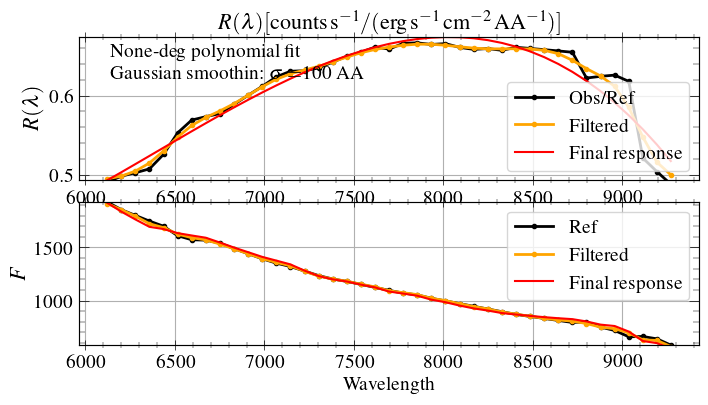

In [118]:
print(results['HILT600'].keys())
results['HILT600']['response_fig']